# Siamese Convolutional Neural Network -- Signature Verification

In [1]:
# own module for preprocessing
from preprocess import PreProcessing
from model import build_model

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import math
import numpy as np

import tensorflow as tf
import keras.backend as K

# model imports
from keras.models import Sequential, Model, Input
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.layers import Dropout, BatchNormalization
from keras.layers import Lambda, concatenate

from keras.initializers import RandomNormal
from tensorflow.keras.regularizers import l2
from keras.optimizers import Adam, RMSprop
from keras.losses import cosine_similarity

from keras.callbacks import EarlyStopping

# plotting
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt

In [2]:
dirs = ['./Weights1', './Weights2', './Weights3']

for x in dirs:
    if not os.path.exists(x):
        os.makedirs(x)

## Setting up datasets

In [3]:
# paths to datasets
PATHS = ["../input/handwritten-signature-datasets/CEDAR/CEDAR",
         "../input/handwritten-signature-datasets/BHSig260-Bengali/BHSig260-Bengali",
         "../input/handwritten-signature-datasets/BHSig260-Hindi/BHSig260-Hindi"]
# number of classes for each
CLASSES = [55,
           100,
           160]

# size of images
SIZE = 224
INPUT_SHAPE = (SIZE, SIZE, 1)

In [4]:
print("Loading %d datasets..." % len(PATHS))

cedar_data = PreProcessing(name='CEDAR',
                           data_path=PATHS[0],
                           size=SIZE)
print("1st dataset loaded successfully!")

bh_bengali_data = PreProcessing(name='BHSig260_Bengali',
                                data_path=PATHS[1],
                                size=SIZE)
print("2nd dataset loaded successfully!")

bh_hindi_data = PreProcessing(name='BHSig260_Hindi',
                              data_path=PATHS[2],
                              size=SIZE)
print("3rd dataset loaded successfully!")

  0%|          | 0/55 [00:00<?, ?it/s]

Loading 3 datasets...


  0%|          | 0/100 [00:00<?, ?it/s]

1st dataset loaded successfully!


100%|██████████| 100/100 [00:53<00:00,  1.86it/s]
/kaggle/usr/lib/preprocess/preprocess.py:108: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  data = np.array(data)
  0%|          | 0/160 [00:00<?, ?it/s]

2nd dataset loaded successfully!


100%|██████████| 160/160 [00:13<00:00, 12.08it/s]


3rd dataset loaded successfully!


In [5]:
DATASETS = [cedar_data, bh_bengali_data, bh_hindi_data]

for x in DATASETS:
    print("Number of classes    : ", x.train_images.shape[0])
    print("Original signatures  : ", len(x.train_images[0][0]))
    print("Forged signatures    : ", len(x.train_images[0][1]))
    print("Image shape          : ", x.train_images[0][0][0].shape)
    print("Number of pairs      : ", x.pairs[0].shape[0])
    print("Targets shape        : ", x.targets.shape)
    print()

Number of classes    :  55
Original signatures  :  24
Forged signatures    :  24
Image shape          :  (224, 224, 1)
Number of pairs      :  600
Targets shape        :  (600,)

Number of classes    :  100
Original signatures  :  24
Forged signatures    :  30
Image shape          :  (224, 224, 1)
Number of pairs      :  600
Targets shape        :  (600,)

Number of classes    :  160
Original signatures  :  24
Forged signatures    :  30
Image shape          :  (224, 224, 1)
Number of pairs      :  600
Targets shape        :  (600,)



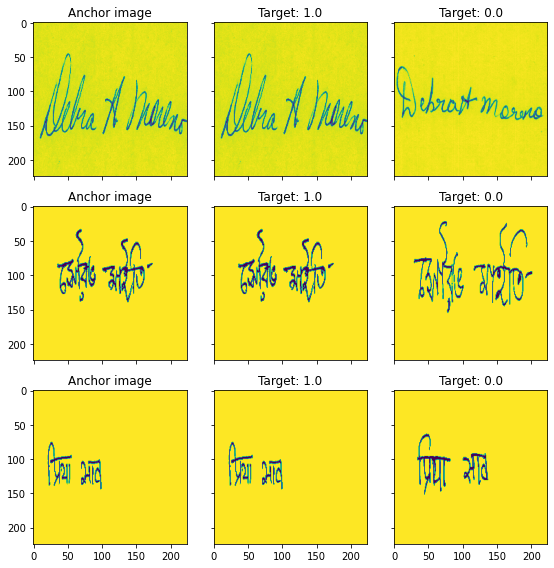

In [6]:
fig, ax = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(8,8))

for i, x in zip(range(3), DATASETS):
    # images : A, P, N
    ax[i,0].imshow(x.pairs[0][0])
    ax[i,1].imshow(x.pairs[1][0])
    ax[i,2].imshow(x.pairs[1][300])
    # subplot titles
    ax[i,0].title.set_text('Anchor image')
    ax[i,1].title.set_text('Target: {0}'.format(x.targets[0]))
    ax[i,2].title.set_text('Target: {0}'.format(x.targets[300]))

plt.tight_layout()

## Setting up model

In [7]:
# hyperparameters
# optimizer
adam = Adam(lr = 0.0001)
rms = RMSprop(lr=1e-4, rho=0.9, epsilon=1e-08)

# number of epochs
EPOCHS = 100

# batch size
BS = 16

### Visualizing model 1

In [8]:
def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
left_input (InputLayer)         [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
right_input (InputLayer)        [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
sequential_network (Sequential) (None, 128)          15374080    left_input[0][0]                 
                                                                 right_input[0][0]                
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0           sequential_network[0][0]     

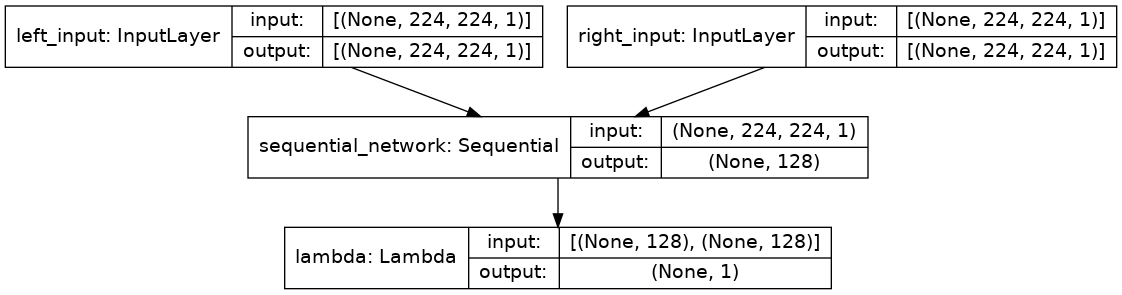

In [9]:
cedar_siamese = build_model(INPUT_SHAPE)

cedar_siamese.compile(optimizer=rms,
                      loss=contrastive_loss)

cedar_siamese.summary()
tf.keras.utils.plot_model(
    cedar_siamese,
    show_shapes=True,
    show_layer_names=True,
    to_file="model_plot1.png"
)

### Training

In [10]:
# callbacks
callbacks = [EarlyStopping(monitor='val_loss', patience=3, verbose=1,)]

history1 = cedar_siamese.fit(
    cedar_data.pairs,
    cedar_data.targets,
    batch_size=BS,
    epochs=EPOCHS,
    verbose=1,
    callbacks=callbacks,
    validation_split=0.2,
)

Epoch 1/100
30/30 [==============================] - 14s 274ms/step - loss: 2.8467 - val_loss: 2.8061
Epoch 2/100
30/30 [==============================] - 7s 226ms/step - loss: 2.1755 - val_loss: 2.6599
Epoch 3/100
30/30 [==============================] - 7s 227ms/step - loss: 1.9129 - val_loss: 2.3852
Epoch 4/100
30/30 [==============================] - 7s 226ms/step - loss: 1.6214 - val_loss: 2.0824
Epoch 5/100
30/30 [==============================] - 7s 227ms/step - loss: 1.3310 - val_loss: 1.8559
Epoch 6/100
30/30 [==============================] - 7s 227ms/step - loss: 1.0992 - val_loss: 1.6692
Epoch 7/100
30/30 [==============================] - 7s 226ms/step - loss: 0.9246 - val_loss: 1.5139
Epoch 8/100
30/30 [==============================] - 7s 227ms/step - loss: 0.7976 - val_loss: 1.3752
Epoch 9/100
30/30 [==============================] - 7s 226ms/step - loss: 0.7062 - val_loss: 1.3022
Epoch 10/100
30/30 [==============================] - 7s 227ms/step - loss: 0.6514 - val_l

In [11]:
cedar_siamese.save_weights('./Weights1/cedar_siamese.h5')

In [12]:
!zip -r weights1.zip ./Weights1

  adding: Weights1/ (stored 0%)
  adding: Weights1/cedar_siamese.h5 (deflated 13%)


### Visualizing history while training

In [13]:
history1.history

{'loss': [2.4511940479278564,
  2.0976452827453613,
  1.8408222198486328,
  1.552757740020752,
  1.2794102430343628,
  1.0636259317398071,
  0.89730304479599,
  0.7792075276374817,
  0.691972553730011,
  0.6304977536201477,
  0.5849405527114868,
  0.4929511845111847,
  0.34309807419776917,
  0.2953203022480011,
  0.24682803452014923,
  0.21284334361553192,
  0.183757945895195,
  0.15947085618972778,
  0.13776858150959015,
  0.1247226819396019,
  0.1082010567188263,
  0.10340198874473572,
  0.09328727424144745,
  0.08130680024623871,
  0.07318765670061111,
  0.06508246809244156,
  0.059570081532001495],
 'val_loss': [2.8061366081237793,
  2.659853935241699,
  2.3852152824401855,
  2.0824360847473145,
  1.8559318780899048,
  1.6692290306091309,
  1.5139089822769165,
  1.3751919269561768,
  1.3022340536117554,
  1.2449816465377808,
  1.112219214439392,
  0.7105638384819031,
  0.4603058993816376,
  0.3900609016418457,
  0.22422410547733307,
  0.4094352424144745,
  0.19056272506713867,
  0.

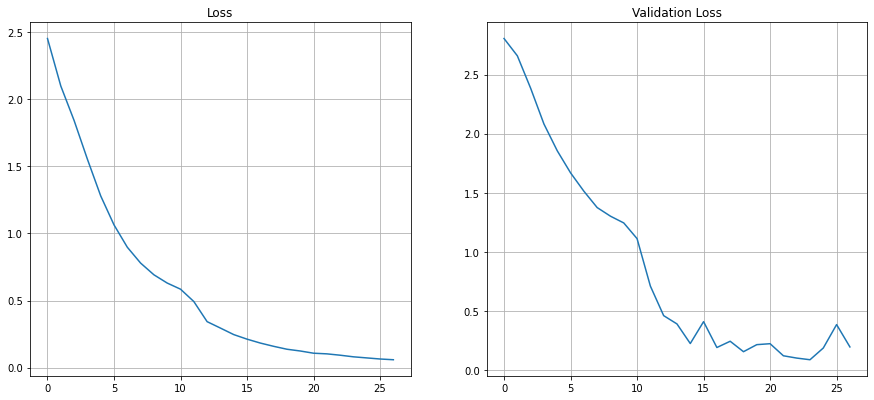

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6.5))
ax1.plot(history1.history['loss'])
ax1.title.set_text('Loss')
ax1.grid(True)

ax2.plot(history1.history['val_loss'])
ax2.title.set_text('Validation Loss')
ax2.grid(True)

plt.show()

### Visualizing model 2

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
left_input (InputLayer)         [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
right_input (InputLayer)        [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
sequential_network (Sequential) (None, 128)          15374080    left_input[0][0]                 
                                                                 right_input[0][0]                
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 1)            0           sequential_network[0][0]   

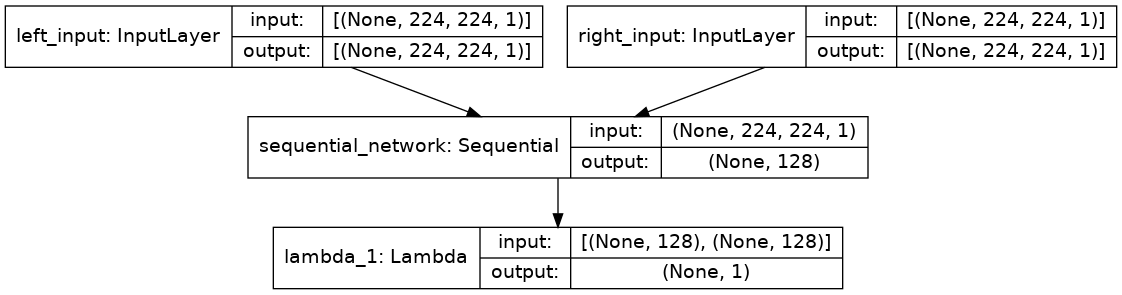

In [15]:
bh_bengali_siamese = build_model(INPUT_SHAPE)

bh_bengali_siamese.compile(optimizer=rms,
                           loss=contrastive_loss)

bh_bengali_siamese.summary()
tf.keras.utils.plot_model(
    bh_bengali_siamese,
    show_shapes=True,
    show_layer_names=True,
    to_file="model_plot2.png"
)

### Training

In [16]:
# callbacks
callbacks = [EarlyStopping(monitor='val_loss', patience=3, verbose=1,)]

history2 = bh_bengali_siamese.fit(
    bh_bengali_data.pairs,
    bh_bengali_data.targets,
    batch_size=BS,
    epochs=EPOCHS,
    verbose=1,
    callbacks=callbacks,
    validation_split=0.2,
)

Epoch 1/100
30/30 [==============================] - 9s 241ms/step - loss: 2.7781 - val_loss: 2.9507
Epoch 2/100
30/30 [==============================] - 7s 226ms/step - loss: 2.2310 - val_loss: 2.7586
Epoch 3/100
30/30 [==============================] - 7s 227ms/step - loss: 2.0096 - val_loss: 2.5386
Epoch 4/100
30/30 [==============================] - 7s 227ms/step - loss: 1.7823 - val_loss: 2.3393
Epoch 5/100
30/30 [==============================] - 7s 226ms/step - loss: 1.5657 - val_loss: 2.1425
Epoch 6/100
30/30 [==============================] - 7s 226ms/step - loss: 1.3772 - val_loss: 1.9821
Epoch 7/100
30/30 [==============================] - 7s 226ms/step - loss: 1.2173 - val_loss: 1.8480
Epoch 8/100
30/30 [==============================] - 7s 227ms/step - loss: 1.0806 - val_loss: 1.7226
Epoch 9/100
30/30 [==============================] - 7s 227ms/step - loss: 0.9688 - val_loss: 1.6256
Epoch 10/100
30/30 [==============================] - 7s 226ms/step - loss: 0.8606 - val_lo

In [17]:
bh_bengali_siamese.save_weights('./Weights2/bh_bengali_siamese.h5')

In [18]:
!zip -r weights2.zip ./Weights2

  adding: Weights2/ (stored 0%)
  adding: Weights2/bh_bengali_siamese.h5 (deflated 8%)


### Visualizing history while training

In [19]:
history2.history

{'loss': [2.4565961360931396,
  2.162569284439087,
  1.958013892173767,
  1.7363840341567993,
  1.5301767587661743,
  1.3452779054641724,
  1.183023452758789,
  1.052700161933899,
  0.9420309066772461,
  0.843091607093811,
  0.7794284224510193,
  0.7176433801651001,
  0.6725956797599792,
  0.624660074710846,
  0.5926535725593567,
  0.5561015009880066,
  0.5271682143211365,
  0.5056053996086121,
  0.48205384612083435,
  0.4692348539829254,
  0.45529937744140625,
  0.4387534260749817,
  0.4310244619846344,
  0.42111554741859436,
  0.3615694046020508,
  0.2709583640098572,
  0.19220729172229767,
  0.1656331717967987,
  0.13335755467414856,
  0.12167182564735413,
  0.10071378201246262,
  0.08528928458690643,
  0.07378890365362167,
  0.06382158398628235,
  0.05597160756587982,
  0.04860977455973625,
  0.04254629835486412,
  0.036155760288238525,
  0.03305625542998314,
  0.03728792443871498],
 'val_loss': [2.9506988525390625,
  2.758636474609375,
  2.5385818481445312,
  2.3393094539642334,
 

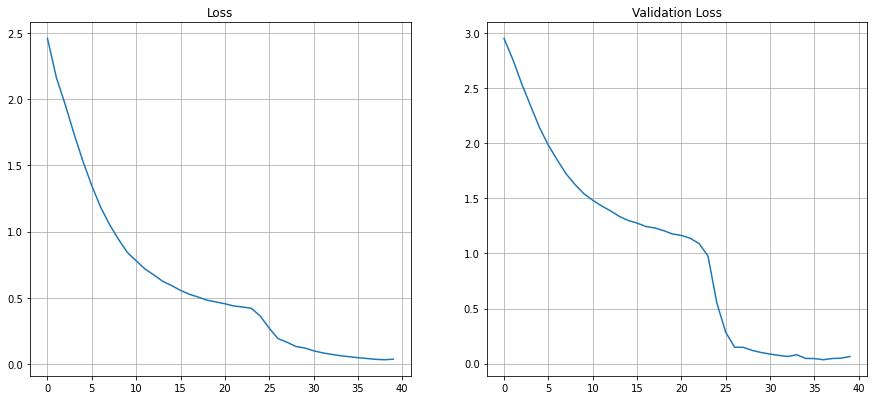

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6.5))
ax1.plot(history2.history['loss'])
ax1.title.set_text('Loss')
ax1.grid(True)

ax2.plot(history2.history['val_loss'])
ax2.title.set_text('Validation Loss')
ax2.grid(True)

plt.show()

### Visualizing model 3

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
left_input (InputLayer)         [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
right_input (InputLayer)        [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
sequential_network (Sequential) (None, 128)          15374080    left_input[0][0]                 
                                                                 right_input[0][0]                
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 1)            0           sequential_network[0][0]   

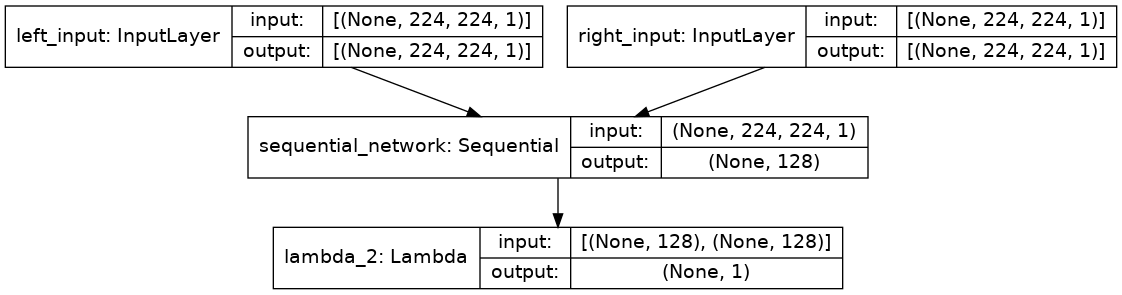

In [21]:
bh_hindi_siamese = build_model(INPUT_SHAPE)

bh_hindi_siamese.compile(optimizer=rms,
                           loss=contrastive_loss)

bh_hindi_siamese.summary()
tf.keras.utils.plot_model(
    bh_hindi_siamese,
    show_shapes=True,
    show_layer_names=True,
    to_file="model_plot3.png"
)

### Training

In [22]:
# callbacks
callbacks = [EarlyStopping(monitor='val_loss', patience=3, verbose=1,)]

history3 = bh_hindi_siamese.fit(
    bh_hindi_data.pairs,
    bh_hindi_data.targets,
    batch_size=BS,
    epochs=EPOCHS,
    verbose=1,
    callbacks=callbacks,
    validation_split=0.2,
)

Epoch 1/100
30/30 [==============================] - 8s 238ms/step - loss: 2.9389 - val_loss: 2.9451
Epoch 2/100
30/30 [==============================] - 7s 227ms/step - loss: 2.2246 - val_loss: 2.7545
Epoch 3/100
30/30 [==============================] - 7s 226ms/step - loss: 2.0290 - val_loss: 2.5532
Epoch 4/100
30/30 [==============================] - 7s 228ms/step - loss: 1.8108 - val_loss: 2.3408
Epoch 5/100
30/30 [==============================] - 7s 226ms/step - loss: 1.5700 - val_loss: 2.1409
Epoch 6/100
30/30 [==============================] - 7s 226ms/step - loss: 1.3616 - val_loss: 1.9669
Epoch 7/100
30/30 [==============================] - 7s 226ms/step - loss: 1.1882 - val_loss: 1.8182
Epoch 8/100
30/30 [==============================] - 7s 226ms/step - loss: 1.0606 - val_loss: 1.7105
Epoch 9/100
30/30 [==============================] - 7s 229ms/step - loss: 0.9527 - val_loss: 1.6216
Epoch 10/100
30/30 [==============================] - 7s 226ms/step - loss: 0.8641 - val_lo

In [23]:
bh_hindi_siamese.save_weights('./Weights3/bh_hindi_siamese.h5')

In [24]:
!zip -r weights3.zip ./Weights3

  adding: Weights3/ (stored 0%)
  adding: Weights3/bh_hindi_siamese.h5 (deflated 5%)


### Visualizing history while training

In [25]:
history3.history

{'loss': [2.5183053016662598,
  2.1805784702301025,
  1.9733651876449585,
  1.7451095581054688,
  1.5258376598358154,
  1.3237591981887817,
  1.164657711982727,
  1.0362493991851807,
  0.9281512498855591,
  0.8472337126731873,
  0.777601420879364,
  0.7173628211021423,
  0.6676055788993835,
  0.62962806224823,
  0.589137077331543,
  0.5605742335319519,
  0.5397266745567322,
  0.515670895576477,
  0.4954995810985565,
  0.4802871346473694,
  0.46125370264053345,
  0.36922216415405273,
  0.21740052103996277,
  0.18397988379001617,
  0.15260551869869232,
  0.12326344102621078],
 'val_loss': [2.9451167583465576,
  2.754530429840088,
  2.55316162109375,
  2.3407862186431885,
  2.1409385204315186,
  1.9668656587600708,
  1.8181614875793457,
  1.7104734182357788,
  1.6215660572052002,
  1.5489165782928467,
  1.488720178604126,
  1.4336365461349487,
  1.3924734592437744,
  1.3523273468017578,
  1.3217109441757202,
  1.2984024286270142,
  1.2709410190582275,
  1.2492051124572754,
  1.23171687126

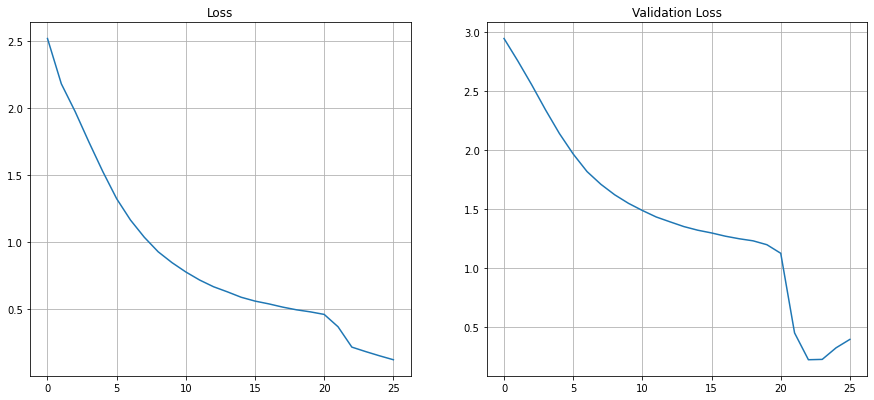

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6.5))
ax1.plot(history3.history['loss'])
ax1.title.set_text('Loss')
ax1.grid(True)

ax2.plot(history3.history['val_loss'])
ax2.title.set_text('Validation Loss')
ax2.grid(True)

plt.show()

## Evaluation for models

In [27]:
def compute_accuracy_roc(predictions, labels, plot_far_frr=True):
    """Compute ROC accuracyand threshold.

    Also, plot FAR-FRR curves and P-R curves for input data.
    
    Args:
        predictions -- np.array : array of predictions.
        labels -- np.array : true labels (0 or 1).
        plot_far_frr -- bool : plots curves of True.
    
    Returns:
        max_acc -- float : maximum accuracy of model.
        best_thresh --float : best threshold for the model.
    """
    dmax = np.max(predictions)
    dmin = np.min(predictions)
    nsame = np.sum(labels == 1) #similar
    ndiff = np.sum(labels == 0) #different
    step = 0.01
    max_acc = 0
    best_thresh = -1
    frr_plot = []
    far_plot = []
    pr_plot = []
    re_plot = []
    ds = []
    for d in np.arange(dmin, dmax+step, step):
        idx1 = predictions.ravel() <= d #guessed genuine
        idx2 = predictions.ravel() > d #guessed forged
        tp = float(np.sum(labels[idx1] == 1))
        tn = float(np.sum(labels[idx2] == 0))
        fp = float(np.sum(labels[idx1] == 0))
        fn = float(np.sum(labels[idx2] == 1))
        tpr = float(np.sum(labels[idx1] == 1)) / nsame       
        tnr = float(np.sum(labels[idx2] == 0)) / ndiff
        
        
        acc = 0.5 * (tpr + tnr)
        pr = tp / (tp + fp)
        re = tp / (tp + fn)
       
        if (acc > max_acc):
            max_acc, best_thresh = acc, d

        far = fp / (fp + tn)
        frr = fn / (fn + tp)
        frr_plot.append(frr)
        pr_plot.append(pr)
        re_plot.append(re)
        far_plot.append(far)
        ds.append(d)
            
    
    if plot_far_frr:
        fig = plt.figure(figsize = (15,6))
        ax = fig.add_subplot(121)
        ax.plot(ds, far_plot, color = 'red')
        ax.plot(ds, frr_plot, color = 'blue')
        ax.set_title('Error rate')
        ax.legend(['FAR', 'FRR'])
        ax.set(xlabel = 'Thresholds', ylabel = 'Error rate')
        
        ax1 = fig.add_subplot(122)
        ax1.plot(ds, pr_plot, color = 'green')
        ax1.plot(ds, re_plot, color = 'magenta')
        ax1.set_title('P-R curve')
        ax1.legend(['Precision', 'Recall'])
        ax.set(xlabel = 'Thresholds', ylabel = 'Error rate')
        
        plt.show()

    return max_acc, best_thresh

### Model 1 - CEDAR

In [28]:
pred1 = cedar_siamese.predict(cedar_data.pairs)
pred1

array([[0.        ],
       [0.00457979],
       [0.014426  ],
       [0.04233709],
       [0.05745029],
       [0.0086241 ],
       [0.01466013],
       [0.04222483],
       [0.00764795],
       [0.03845878],
       [0.03845878],
       [0.03845878],
       [0.03845878],
       [0.03845878],
       [0.03845878],
       [0.03845878],
       [0.03845878],
       [0.03845878],
       [0.03845878],
       [0.03845878],
       [0.03845878],
       [0.03845878],
       [0.03845878],
       [0.03845878],
       [0.0383022 ],
       [0.0383022 ],
       [0.0383022 ],
       [0.0383022 ],
       [0.01893424],
       [0.0122415 ],
       [0.03966153],
       [0.00612949],
       [0.0336111 ],
       [0.00420364],
       [0.03184059],
       [0.0086867 ],
       [0.02250513],
       [0.02490356],
       [0.01794096],
       [0.03531729],
       [0.07112353],
       [0.02930405],
       [0.07483076],
       [0.04659048],
       [0.04312471],
       [0.03792834],
       [0.0214921 ],
       [0.   

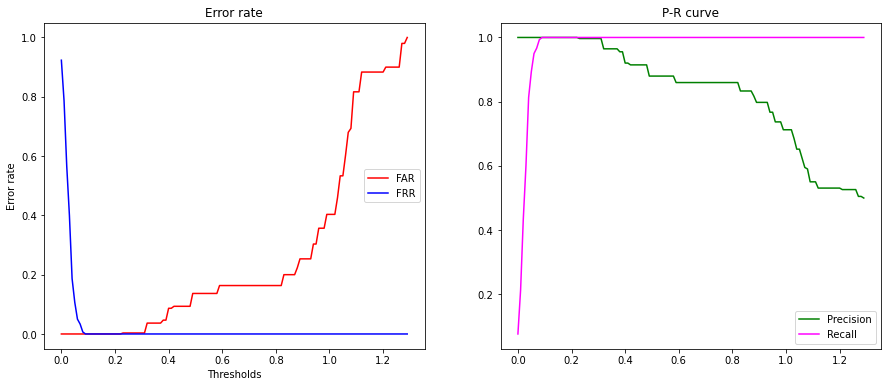

In [29]:
acc1, thresh1 = compute_accuracy_roc(pred1, cedar_data.targets)

### Model 2 - BhSig260 Bengali

In [30]:
pred2 = bh_bengali_siamese.predict(bh_bengali_data.pairs)
pred2

array([[0.        ],
       [0.03676683],
       [0.01319555],
       [0.05801636],
       [0.02102314],
       [0.00764469],
       [0.02353459],
       [0.02303944],
       [0.01045199],
       [0.05187295],
       [0.01063537],
       [0.02926977],
       [0.01178194],
       [0.05175907],
       [0.03444009],
       [0.04559841],
       [0.04083882],
       [0.04595614],
       [0.03582818],
       [0.03536562],
       [0.07855909],
       [0.02103483],
       [0.07786085],
       [1.7393485 ],
       [2.5165427 ],
       [2.5165427 ],
       [2.5165427 ],
       [2.5165427 ],
       [2.5165427 ],
       [2.5165427 ],
       [2.5165427 ],
       [2.202829  ],
       [0.01709841],
       [0.0300531 ],
       [0.01823879],
       [0.02670242],
       [0.01776497],
       [0.01041836],
       [0.01695673],
       [0.01204325],
       [0.02171102],
       [0.03573152],
       [0.01760244],
       [0.04573093],
       [0.04358615],
       [0.04928003],
       [0.0136681 ],
       [0.   

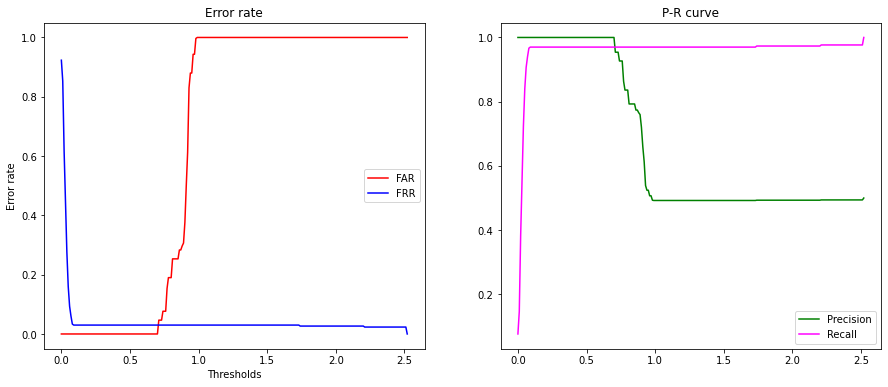

In [31]:
acc2, thresh2 = compute_accuracy_roc(pred2, bh_bengali_data.targets)

### Model 3 - BhSig260 Hindi

In [32]:
pred3 = bh_hindi_siamese.predict(bh_hindi_data.pairs)
pred3

array([[0.        ],
       [0.00615311],
       [0.01135033],
       [0.01361118],
       [0.00532285],
       [0.00835956],
       [0.02409929],
       [0.00687998],
       [0.00592339],
       [0.014796  ],
       [0.02318713],
       [0.015519  ],
       [0.00622637],
       [0.01264511],
       [0.00570353],
       [0.01975048],
       [0.02695133],
       [0.02229542],
       [0.02704766],
       [0.0185593 ],
       [0.0096226 ],
       [0.00890246],
       [0.02718836],
       [0.00755187],
       [0.        ],
       [0.01269919],
       [0.01516431],
       [0.00415823],
       [0.01018122],
       [0.02378797],
       [0.00570018],
       [0.0082174 ],
       [0.01422185],
       [0.02308333],
       [0.0167929 ],
       [0.00415067],
       [0.01295749],
       [0.00793817],
       [0.01960047],
       [0.02730997],
       [0.0226106 ],
       [0.02712293],
       [0.01958903],
       [0.00923868],
       [0.00801871],
       [0.02794241],
       [0.0081925 ],
       [0.   

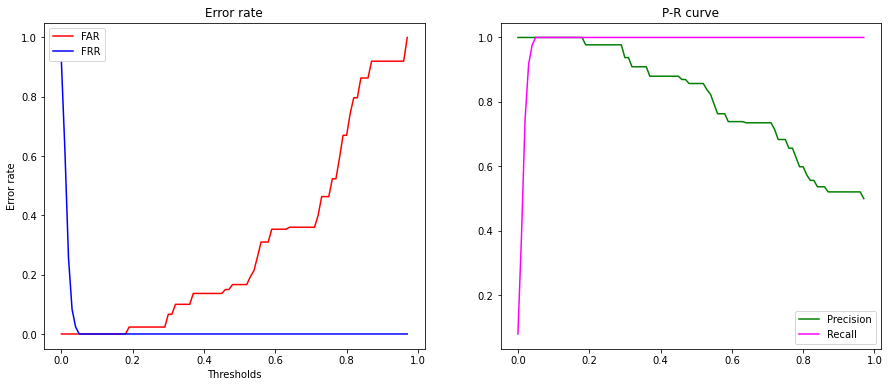

In [33]:
acc3, thresh3 = compute_accuracy_roc(pred3, bh_hindi_data.targets)

### Accuracies and threholds

In [34]:
from pandas import DataFrame
df = DataFrame.from_dict({'Accuracies': [acc1*100, acc2*100, acc3*100],
                          'Thresholds': [thresh1, thresh2, thresh3]},)
df.index = ['Cedar', 'BhSig260 Bengali', 'BhSig260 Hindi']
df

,Accuracies,Thresholds
Cedar,100.0,0.09
BhSig260 Bengali,98.5,0.09
BhSig260 Hindi,100.0,0.05
